# Project Ranking Over Time

In this notebook, we would like to understand the project rankings and how they vary over time for different CNCF projects. Using the graphical techniques such as PageRank, Betweenness and Closeness Centrality scores we can identify the rank for each project in a given time range.

## Connect to Augur database

We will be fetching the data from an Augur database which stores the GitHub data for a large number of open source repositories.

In [1]:
import pandas as pd
import psycopg2
import itertools
import collections
from operator import itemgetter
import sqlalchemy as salc
import json
import networkx as nx
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import plotly

from ipynb.fs.defs.graph_helper_functions import (
     get_all_repos,
     get_repos,
     get_contributors,
     created_melted_dfs,
     get_repos_outside,
     get_page_ranks,
     get_betweenness_centrality,
     get_closeness_centrality,
     plot_graph,
     project_nodes_edges_contributions
)

with open("../wasm_creds.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [3]:
READ_LOCALLY = False

## Retrieve Available Repositories

Fetch all the repositories for the WASM ecosystem.

In [4]:
df_repos = get_all_repos(engine)

In [5]:
df_repos.head()

,repo_id,repo_group_id,repo_git,repo_path,repo_name,repo_added,repo_type,url,owner_id,description,primary_language,created_at,forked_from,updated_at,repo_archived_date_collected,repo_archived,tool_source,tool_version,data_source,data_collection_date
0,25598,25432,https://github.com/fluencelabs/musl,github.com-fluencelabs-musl,musl,2023-08-01 08:24:29,Organization,None,None,None,None,None,LinusU/musl,None,None,0,Frontend,1.0,Git,2023-08-01 08:24:29
1,25492,25430,https://github.com/wasmerio/wasmer,github.com-wasmerio-wasmer,wasmer,2023-08-01 08:24:09,Organization,None,None,None,None,None,Parent not available,None,None,0,Frontend,1.0,Git,2023-08-01 08:24:09
2,25509,25431,https://github.com/ewasm/hera,github.com-ewasm-hera,hera,2023-08-01 08:24:16,Organization,None,None,None,None,None,Parent not available,None,None,0,Frontend,1.0,Git,2023-08-01 08:24:16
3,25641,25432,https://github.com/fluencelabs/js-client,github.com-fluencelabs-js-client,js-client,2023-08-01 08:24:29,Organization,None,None,None,None,None,Parent not available,None,None,0,Frontend,1.0,Git,2023-08-01 08:24:29
4,25490,25430,https://github.com/bytecodealliance/wasmtime,github.com-bytecodealliance-wasmtime,wasmtime,2023-08-01 08:24:09,Organization,None,None,None,None,None,Parent not available,None,None,0,Frontend,1.0,Git,2023-08-01 08:24:09


In [6]:
df_repos.repo_id.nunique()

258

In [7]:
# Let's subset the df for just 30 repo ids for testing purposes only
repo_set = random.sample(df_repos['repo_id'].unique().tolist(), 30)

In [8]:
df_subset = df_repos[df_repos['repo_id'].isin(repo_set)]

In [9]:
# Extract corresponding names into a list
repo_names = df_subset['repo_name'].tolist()

In [10]:
repos = {"repo_names": repo_names}

In [11]:
repos

{'repo_names': ['wasmer',
  'web3.js',
  'ewasm-cleanup',
  'wasm-gc',
  'ethereum-bls12.rs',
  'ewasm-precompiles',
  'slides',
  'dweb-camp-peer-to-peer',
  'lumos-hackathon',
  'aqua-vscode',
  'crossmodule',
  'fluence-shared-canvas',
  'docs',
  'github-actions',
  'deal',
  'sentinel-governance',
  'ethdenver-buidl-2022',
  'dashboard',
  'dcc-wg',
  'xwasm',
  'aqua-lib',
  'llamadb-wasm',
  'wasm-metering-old',
  'zwitterion',
  'wasm-timer',
  'glas',
  'wasmi',
  'spec',
  'tendermint-demo',
  'jsonpath']}

## Retrieve All Contributors

In [12]:
if READ_LOCALLY:
    contrib_df = pd.read_pickle("ep_data/all_contrib.pkl")
else:
    contrib_df = get_contributors(repo_set, engine)
    contrib_df['created_at'] = pd.to_datetime(contrib_df['created_at'], utc=True)
    contrib_df['created_at'] = contrib_df['created_at'].dt.strftime('%Y-%m-%d')
    contrib_df['created_at'] = pd.to_datetime(contrib_df['created_at']).dt.normalize()
    contrib_df.to_pickle("ep_data/all_contrib.pkl")

In [13]:
contrib_df.head()

,cntrb_id,created_at,repo_id,action,repo_name,login,rank
0,010031ea-2100-0000-0000-000000000000,2018-07-09,25581,commit,spec,Honry,3
1,010031ea-2100-0000-0000-000000000000,2018-07-10,25581,commit,spec,Honry,4
2,010031ea-2100-0000-0000-000000000000,2018-07-09,25581,commit,spec,Honry,2
3,010031ea-2100-0000-0000-000000000000,2018-07-09,25581,commit,spec,Honry,1
4,010040ce-3b00-0000-0000-000000000000,2018-07-09,25581,commit,spec,rossberg,565


In [14]:
contrib_df.repo_name.nunique()

30

In [15]:
contrib_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53853 entries, 0 to 53852
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   cntrb_id    53773 non-null  object        
 1   created_at  53853 non-null  datetime64[ns]
 2   repo_id     53853 non-null  int64         
 3   action      53853 non-null  object        
 4   repo_name   53853 non-null  object        
 5   login       53773 non-null  object        
 6   rank        53853 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 2.9+ MB


## Graph Type 1: Projects and Contributors as Nodes

In this section, we plot projects and contributors on the same graph as nodes and color them differently to see the relationships between them.

In [16]:
repo_contributions = contrib_df.groupby(['repo_name', 'cntrb_id', 'created_at']).size().unstack(fill_value=0)
repo_contributions = repo_contributions.reset_index()
repo_contributions.head()

created_at,repo_name,cntrb_id,2021-04-30 00:00:00,2021-05-03 00:00:00,2021-05-27 00:00:00,2021-06-03 00:00:00,2021-09-08 00:00:00,2021-10-26 00:00:00,2021-11-24 00:00:00,2022-02-04 00:00:00,...,2018-09-10 00:00:00,2018-05-28 00:00:00,2018-05-29 00:00:00,2018-07-13 00:00:00,2018-07-21 00:00:00,2018-07-23 00:00:00,2018-09-09 00:00:00,2020-01-30 00:00:00,2022-03-26 00:00:00,2020-07-19 00:00:00
0,aqua-lib,01000a6e-9400-0000-0000-000000000000,2,2,4,2,3,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,aqua-lib,01000b8d-8500-0000-0000-000000000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,aqua-lib,01001229-7100-0000-0000-000000000000,0,1,0,2,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,aqua-lib,01001dbe-ac00-0000-0000-000000000000,0,0,0,5,0,3,2,3,...,0,0,0,0,0,0,0,0,0,0
4,aqua-lib,01003e30-3400-0000-0000-000000000000,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
df_melted = repo_contributions.melt(
    id_vars=['repo_name', 'cntrb_id'],
    var_name = 'date', value_name='number'
)
df_melted = df_melted[df_melted[df_melted.columns[3]] != 0]
df_melted.head()

,repo_name,cntrb_id,date,number
0,aqua-lib,01000a6e-9400-0000-0000-000000000000,2021-04-30,2
251,wasmer,010002df-6100-0000-0000-000000000000,2021-04-30,53
284,wasmer,010005fd-cc00-0000-0000-000000000000,2021-04-30,2
332,wasmer,01000e6f-b800-0000-0000-000000000000,2021-04-30,1
374,wasmer,01001685-1400-0000-0000-000000000000,2021-04-30,1


In [18]:
df_melted.rename(columns = {'number':'total_contributions'}, inplace = True)

In [19]:
df_melted.head()

,repo_name,cntrb_id,date,total_contributions
0,aqua-lib,01000a6e-9400-0000-0000-000000000000,2021-04-30,2
251,wasmer,010002df-6100-0000-0000-000000000000,2021-04-30,53
284,wasmer,010005fd-cc00-0000-0000-000000000000,2021-04-30,2
332,wasmer,01000e6f-b800-0000-0000-000000000000,2021-04-30,1
374,wasmer,01001685-1400-0000-0000-000000000000,2021-04-30,1


In [20]:
df_melted['year'] = df_melted['date'].dt.year

In [21]:
df_melted.head()

,repo_name,cntrb_id,date,total_contributions,year
0,aqua-lib,01000a6e-9400-0000-0000-000000000000,2021-04-30,2,2021
251,wasmer,010002df-6100-0000-0000-000000000000,2021-04-30,53,2021
284,wasmer,010005fd-cc00-0000-0000-000000000000,2021-04-30,2,2021
332,wasmer,01000e6f-b800-0000-0000-000000000000,2021-04-30,1,2021
374,wasmer,01001685-1400-0000-0000-000000000000,2021-04-30,1,2021


In [22]:
len(df_melted)

11954

In [23]:
# find the total number of contributions made by each contributor in that year
grouped_contributions_year = df_melted.groupby(['repo_name', 'cntrb_id', 'year'])['total_contributions'].sum()

In [24]:
grouped_contributions_year = grouped_contributions_year.reset_index()
grouped_contributions_year.head()

,repo_name,cntrb_id,year,total_contributions
0,aqua-lib,01000a6e-9400-0000-0000-000000000000,2021,15
1,aqua-lib,01000a6e-9400-0000-0000-000000000000,2022,6
2,aqua-lib,01000b8d-8500-0000-0000-000000000000,2021,1
3,aqua-lib,01001229-7100-0000-0000-000000000000,2021,13
4,aqua-lib,01001229-7100-0000-0000-000000000000,2022,7


In [25]:
len(grouped_contributions_year)

1491

### Plot Graphs

### Use PageRank and Betweenness Centrality to Subset Nodes

We can now try to run the `PageRank` algorithm to compute the ranking of the nodes in the graph based on the structure of the incoming links. 

We will also look into the betweenness centrality in the graph to compute the shortest-path betweenness centrality for nodes. It measures how often a node occurs on all shortest paths between two nodes. Here we are trying to analyze which are the common repositories that occur on all paths in the graph. 

### Page Rank

PageRank ranks important nodes by analyzing the quantity and quality of the links that point to it. In our case, links that point to repositories come from contributors. 

#### Run PageRank grouped by year

In [26]:
yearly_score_dict = dict()

In [27]:
yearly_score_dict

{}

In [28]:
repo_scores = pd.DataFrame(
    {'repo': repo_names
    })

In [29]:
all_years = grouped_contributions_year["year"].unique()

In [30]:
def get_page_rank_scores(df, repos, scores):
        
    bi_df = df.rename(columns={"repo_name": "cntrb_id", "cntrb_id": "repo_name"}, inplace=False)

    bidirect_df = pd.concat([df, bi_df], ignore_index=True)
    
    # Creating a directed graph to run page rank
    H = nx.from_pandas_edgelist(bidirect_df,
                            source='cntrb_id',
                            target='repo_name',
                            edge_attr='total_contributions',
                            create_using=nx.DiGraph())
    
    top_repos, pageranks, scores = get_page_ranks(H, 100, repos, scores)  

    return scores

### Betweenness Centrality

In [31]:
def get_betweenness_centrality_scores(df, repos, scores):
        
    G = nx.from_pandas_edgelist(df, 
                            source='repo_name',
                            target='cntrb_id',
                            edge_attr='total_contributions',
                            create_using=nx.Graph())
    
    top_repos, bc, scores = get_betweenness_centrality(G, 50, repos, scores)  

    return scores

In [32]:
def get_closeness_centrality_scores(df, repos, scores):
    
    result, common_repo_contri = project_nodes_edges_contributions(df)
    
    g = nx.Graph()
    g.add_weighted_edges_from(result)
    
    graphs = [g.subgraph(c) for c in nx.connected_components(g)]
    
    sub_graphs = []
    for g in graphs:
        n = g.nodes()
        if g.number_of_nodes() > 5 and (set(n) & set(repo_names)):
            sub_graphs.append(g)
            
    if len(sub_graphs) > 0:
        top_repos, cc, scores = get_closeness_centrality(sub_graphs[0], 100, repos, scores)
        
    return scores

In [33]:
# Create subsets of the DataFrame based on the unique values in the 'year' column
for year in all_years:
    
    subset_df = grouped_contributions_year[grouped_contributions_year["year"] == year]
    
    repo_scores = get_page_rank_scores(subset_df, repos, repo_scores)
    repo_scores = get_betweenness_centrality_scores(subset_df, repos, repo_scores)
    repo_scores = get_closeness_centrality_scores(subset_df, repos, repo_scores)
    
    yearly_score_dict[year] = repo_scores.copy()

In [34]:
yearly_score_dict

{2021:                       repo  page_rank  betweenness_centrality
 0                   wasmer   0.379265                0.929272
 1                  web3.js        NaN                     NaN
 2            ewasm-cleanup        NaN                     NaN
 3                  wasm-gc        NaN                     NaN
 4        ethereum-bls12.rs        NaN                     NaN
 5        ewasm-precompiles        NaN                     NaN
 6                   slides        NaN                     NaN
 7   dweb-camp-peer-to-peer        NaN                     NaN
 8          lumos-hackathon        NaN                     NaN
 9              aqua-vscode   0.004103                0.000046
 10             crossmodule        NaN                     NaN
 11   fluence-shared-canvas        NaN                     NaN
 12                    docs        NaN                     NaN
 13          github-actions        NaN                     NaN
 14                    deal        NaN           

In [118]:
yearly_score_df = pd.concat(yearly_score_dict.values(), keys=yearly_score_dict.keys()).reset_index()

In [119]:
yearly_score_df.head()

,level_0,level_1,repo,page_rank,betweenness_centrality,closeness_centrality
0,2021,0,wasmer,0.379265,0.929272,NaN
1,2021,1,web3.js,NaN,NaN,NaN
2,2021,2,ewasm-cleanup,NaN,NaN,NaN
3,2021,3,wasm-gc,NaN,NaN,NaN
4,2021,4,ethereum-bls12.rs,NaN,NaN,NaN


In [120]:
yearly_score_df = yearly_score_df.rename(columns={'level_0': 'year'})

In [121]:
yearly_score_df.head()

,year,level_1,repo,page_rank,betweenness_centrality,closeness_centrality
0,2021,0,wasmer,0.379265,0.929272,NaN
1,2021,1,web3.js,NaN,NaN,NaN
2,2021,2,ewasm-cleanup,NaN,NaN,NaN
3,2021,3,wasm-gc,NaN,NaN,NaN
4,2021,4,ethereum-bls12.rs,NaN,NaN,NaN


In [122]:
yearly_score_df = yearly_score_df[['repo', 'year', 'page_rank', 'betweenness_centrality', 'closeness_centrality']]

In [123]:
yearly_score_df.head()

,repo,year,page_rank,betweenness_centrality,closeness_centrality
0,wasmer,2021,0.379265,0.929272,NaN
1,web3.js,2021,NaN,NaN,NaN
2,ewasm-cleanup,2021,NaN,NaN,NaN
3,wasm-gc,2021,NaN,NaN,NaN
4,ethereum-bls12.rs,2021,NaN,NaN,NaN


In [124]:
len(yearly_score_df)

300

In [125]:
yearly_score_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   repo                    300 non-null    object 
 1   year                    300 non-null    int64  
 2   page_rank               82 non-null     float64
 3   betweenness_centrality  82 non-null     float64
 4   closeness_centrality    72 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 11.8+ KB


In [126]:
yearly_score_df['year'] = pd.to_datetime(yearly_score_df['year'], format='%Y').dt.strftime('%Y')

In [127]:
yearly_score_df['year']

0      2021
1      2021
2      2021
3      2021
4      2021
       ... 
295    2014
296    2014
297    2014
298    2014
299    2014
Name: year, Length: 300, dtype: object

In [128]:
scaler = MinMaxScaler()

def calculate_scores(df):
    df[['page_rank', 'betweenness_centrality', 'closeness_centrality']] = scaler.fit_transform(df[['page_rank', 'betweenness_centrality', 'closeness_centrality']])
    df['total_score'] = df.apply(lambda row: row.page_rank + row.betweenness_centrality + row.closeness_centrality, axis = 1)
    return df

In [129]:
yearly_repo_scores = calculate_scores(yearly_score_df)

In [130]:
yearly_repo_scores.head()

,repo,year,page_rank,betweenness_centrality,closeness_centrality,total_score
0,wasmer,2021,0.804512,0.929272,NaN,NaN
1,web3.js,2021,NaN,NaN,NaN,NaN
2,ewasm-cleanup,2021,NaN,NaN,NaN,NaN
3,wasm-gc,2021,NaN,NaN,NaN,NaN
4,ethereum-bls12.rs,2021,NaN,NaN,NaN,NaN


In [131]:
yearly_repo_scores.sort_values("total_score", ascending=False, inplace=True)

In [132]:
yearly_repo_scores.reset_index(drop=True, inplace=True)

In [133]:
yearly_repo_scores.head()

,repo,year,page_rank,betweenness_centrality,closeness_centrality,total_score
0,wasmer,2020,0.789266,0.957580,0.765625,2.512471
1,wasmer,2019,0.643169,0.844266,0.464286,1.951721
2,wasmer,2023,0.661147,0.893417,0.307065,1.861630
3,wasmer,2018,0.184474,0.221723,0.765625,1.171822
4,docs,2022,0.034010,0.005469,1.000000,1.039479


## Visualizations

### 1. Bar Chart - Compare ranks over time

In [134]:
yearly_repo_scores = yearly_repo_scores.sort_values(by='year')

In [135]:
yearly_repo_scores.reset_index(inplace=True, drop=True)

In [136]:
yearly_repo_scores.head()

,repo,year,page_rank,betweenness_centrality,closeness_centrality,total_score
0,jsonpath,2014,NaN,NaN,0.420455,NaN
1,deal,2014,NaN,NaN,NaN,NaN
2,github-actions,2014,NaN,NaN,NaN,NaN
3,docs,2014,NaN,NaN,NaN,NaN
4,fluence-shared-canvas,2014,NaN,NaN,NaN,NaN


In [137]:
yearly_repo_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   repo                    300 non-null    object 
 1   year                    300 non-null    object 
 2   page_rank               82 non-null     float64
 3   betweenness_centrality  82 non-null     float64
 4   closeness_centrality    72 non-null     float64
 5   total_score             43 non-null     float64
dtypes: float64(4), object(2)
memory usage: 14.2+ KB


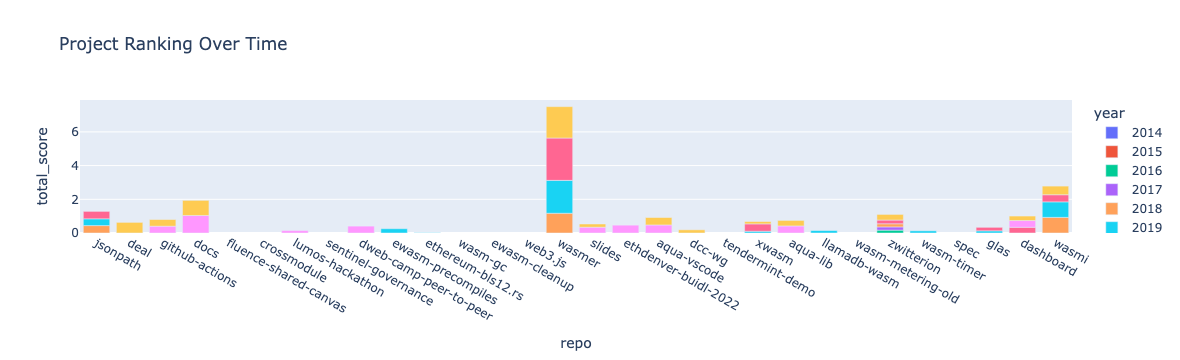

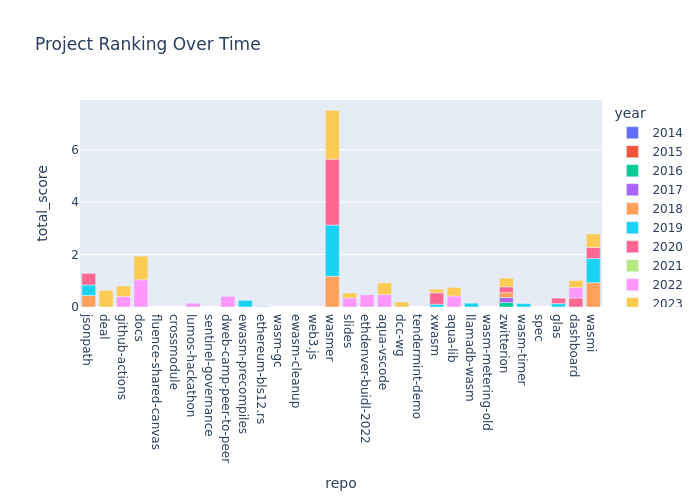

In [145]:
fig = px.bar(yearly_repo_scores, x='repo', y='total_score', color='year', title='Project Ranking Over Time')
fig.show("")
fig.show("png")

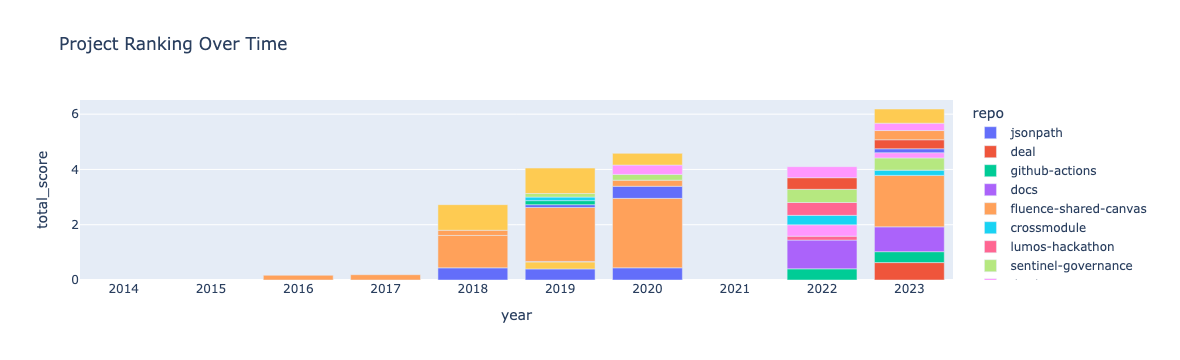

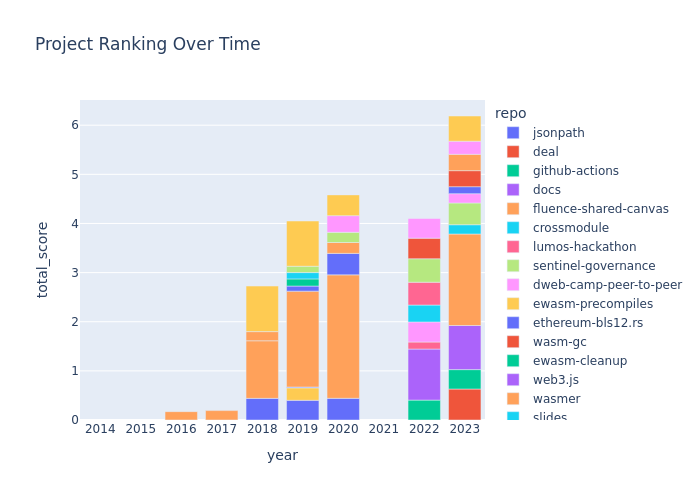

In [146]:
fig = px.bar(yearly_repo_scores, x='year', y='total_score', color='repo', title='Project Ranking Over Time')
fig.show("")
fig.show("png")

### 2. Line Plot - Trend in rankings over time

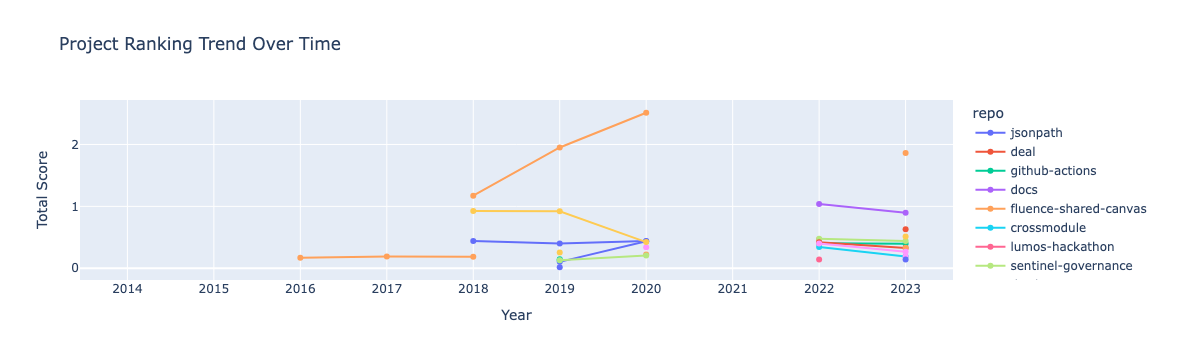

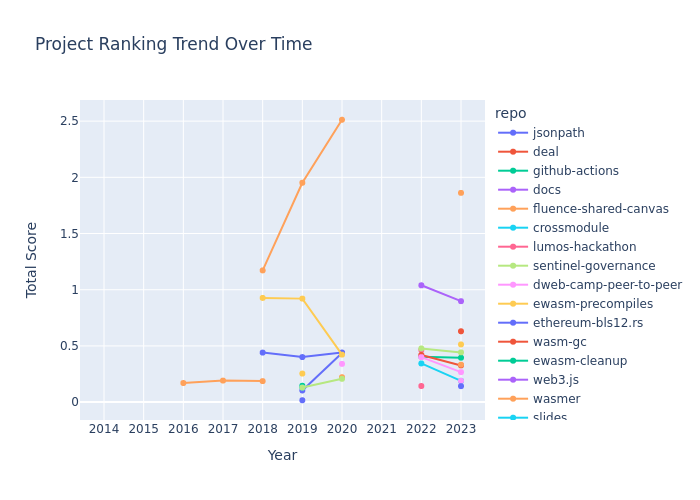

In [147]:
fig = px.line(yearly_repo_scores, x='year', y='total_score', color='repo', markers=True, title='Project Ranking Trend Over Time')
fig.update_layout(xaxis_title='Year', yaxis_title='Total Score')
fig.show("")
fig.show("png")

### 3. Box Plots - Distribution of scores for each repo 

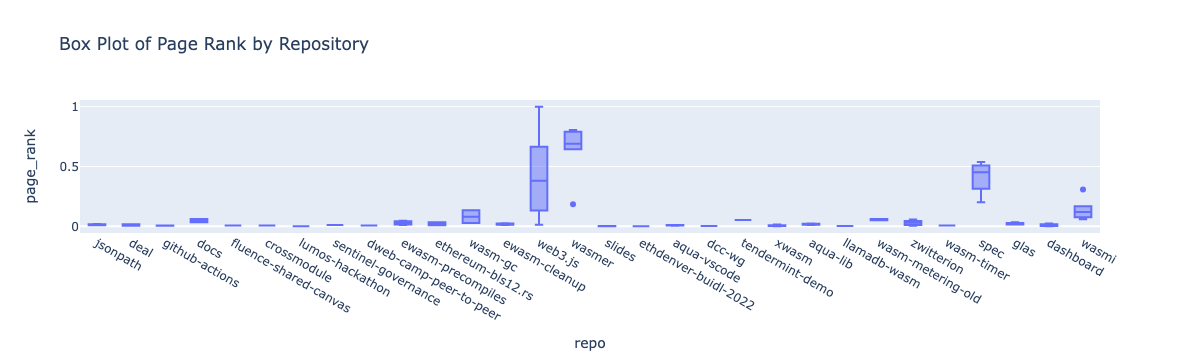

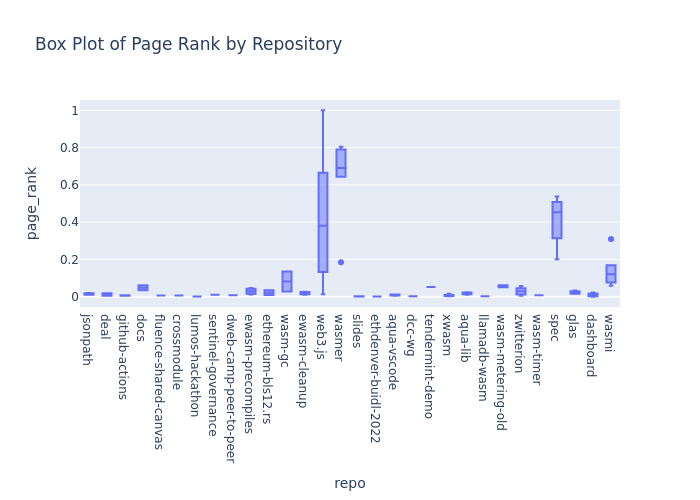

In [148]:
fig = px.box(yearly_repo_scores, x='repo', y='page_rank', title='Box Plot of Page Rank by Repository')
fig.show("")
fig.show("png")

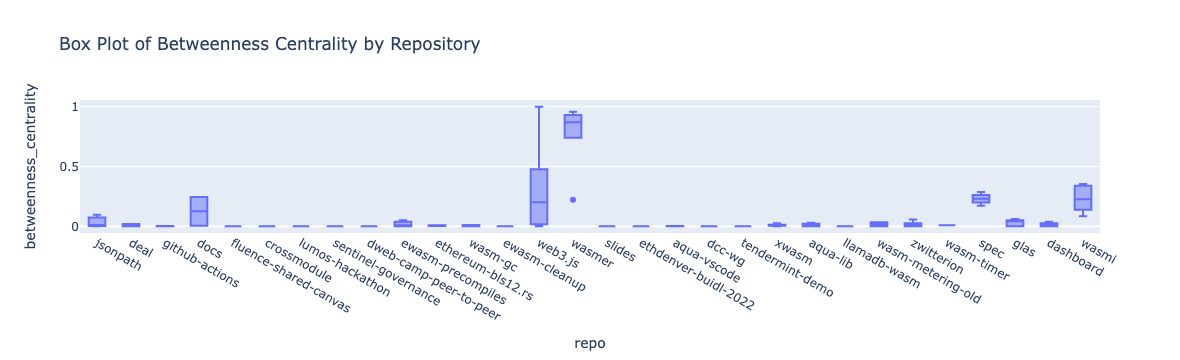

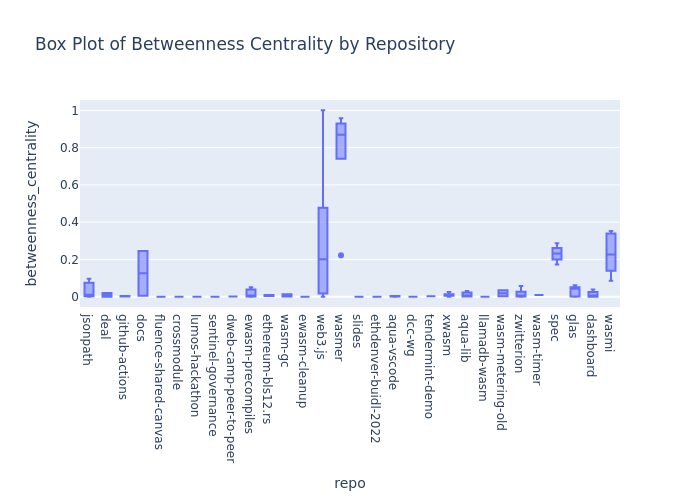

In [149]:
fig = px.box(yearly_repo_scores, x='repo', y='betweenness_centrality', title='Box Plot of Betweenness Centrality by Repository')
fig.show("")
fig.show("png")

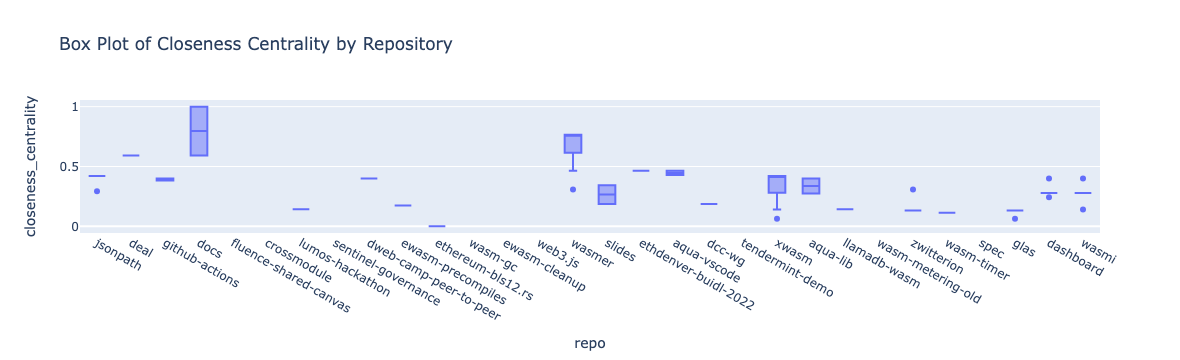

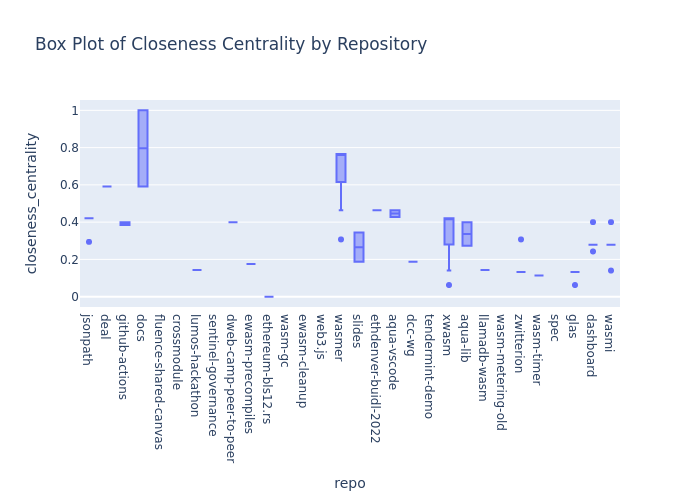

In [150]:
fig = px.box(yearly_repo_scores, x='repo', y='closeness_centrality', title='Box Plot of Closeness Centrality by Repository')
fig.show("")
fig.show("png")